In [7]:
from typing import get_args

import numpy as np

from sippy_unipi.datasets import gen_gbn_seq, load_sample_mimo, white_noise
from sippy_unipi.io import (
    ARARMAX,
    ARARX,
    ARMA,
    ARMAX,
    ARX,
    BJ,
    FIR,
    GEN,
    OE,
    BaseInputOutput,
)
from sippy_unipi.model_selection import GridSearchCV
from sippy_unipi.plot import plot_comparison
from sippy_unipi.ss import SSModel
from sippy_unipi.typing import AvailableModes

# Enable automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
time, Y, U, g_sys, Yerr, Uerr, h_sys, Y, U = load_sample_mimo()

### Define System Parameters

In [3]:
# Sample time
ts = 1.0

# SISO SS system (n = 2)
A = np.array([[0.89, 0.0], [0.0, 0.45]])
B = np.array([[0.3], [2.5]])
C = np.array([[0.7, 1.0]])
D = np.array([[0.0]])

sys_true = SSModel._from_state(A, B, C, D)
tfin = 500
npts = int(tfin // ts) + 1
time = np.linspace(0, tfin, npts)

### Generate Input Sequence and System Output

In [4]:
# Input sequence
U = gen_gbn_seq(npts, 0.05).reshape(-1, 1)

# Output
Y = sys_true.predict(U) + white_noise(0.15, (npts, 1))

In [6]:
models = [
    FIR(),
    ARMAX(),
    ARX(),
    ARMA(),
    ARARX(),
    ARARMAX(),
    OE(),
    BJ(),
    GEN(),
]

param_grid = {"method": get_args(AvailableModes)}

Y_preds = [Y]
for model in models:
    model: BaseInputOutput
    model_search = GridSearchCV(model, param_grid)
    model_search.fit(U, Y)
    Y_preds.append(model_search.predict(U))

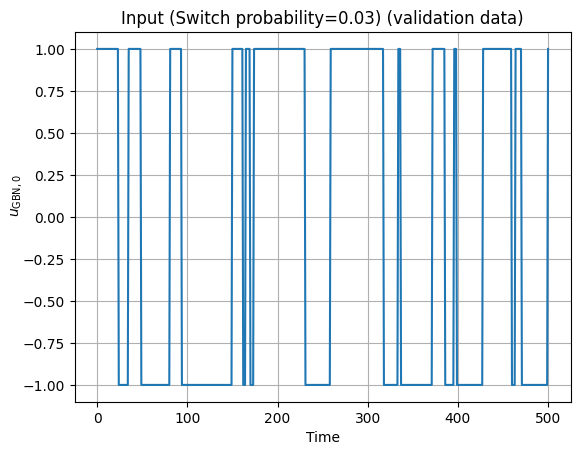

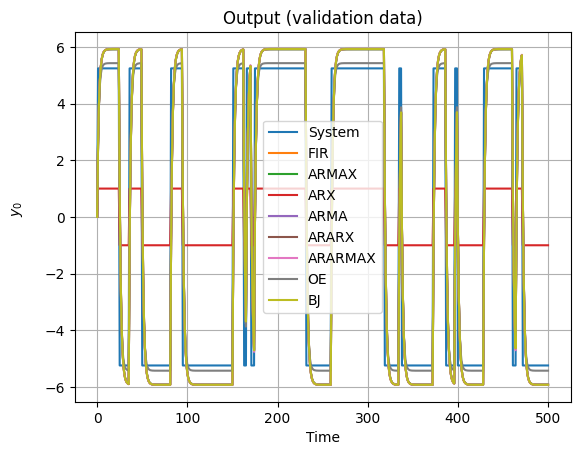

In [13]:
fig = plot_comparison(
    time,
    U,
    [r"$u_\mathrm{GBN, " + str(i) + "}$" for i in range(U.shape[1])],
    title="Input (Switch probability=0.03) (validation data)",
)

fig = plot_comparison(
    time,
    Y_preds,
    ylabels=[f"$y_{i}$" for i in range(3)],
    legend=["System"] + [model.__class__.__name__ for model in models],
    title="Output (validation data)",
)